In [53]:
#!pip install tqdm

In [54]:
#!pip install pandas

In [55]:
#!pip install nltk

In [56]:
#!pip install -U spacy

In [57]:
#!pip install es_core_news_sm

In [58]:
#!pip install scikit-learn

In [59]:
#!pip install matplotlib

In [60]:
#!pip install seaborn

In [61]:
#!pip install cltk

In [62]:
#!pip install scikit-plot

In [63]:
#!pip install imblearn

In [64]:
import os
os.chdir("/home/martinaleo/.ssh/authorship/pydro")
from src.dro import DistributionalRandomOversampling



# Imports

In [67]:
from tqdm import tqdm

from data_loader import load_spanish_corpus

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import re

from nltk import download
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import spacy
import es_core_news_sm

from splitting__ import Segmentation

from helpers__ import get_function_words

from features import ( 
    FeaturesFunctionWords, 
    FeaturesDVEX, 
    FeaturesMendenhall, 
    FeaturesSentenceLength, 
    FeaturesPOST, 
    FeatureSetReductor,
    HstackFeatureSet
)


from sklearn.feature_selection import SelectKBest, chi2

from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV,
)

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

from scikitplot.metrics import plot_roc
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE


# Data Loading

In [68]:
documents, authors, filenames = load_spanish_corpus(path='/home/martinaleo/authorship/src/data/Corpus')

loading: /home/martinaleo/authorship/src/data/Corpus: 100%|██████████| 31/31 [00:00<00:00, 653.00it/s]


In [69]:
print(filenames)

['Agustín de Rojas Villandrando - El viaje entretenido', 'Alonso de Castillo Solórzano - Aventuras del Bachiller Trapaza', 'Alonso de Castillo Solórzano - Las harpías en Madrid y coche de las estafas', 'Avellaneda - Quijote apocrifo', 'Cervantes - El amante liberal', 'Cervantes - El casamiento engañoso', 'Cervantes - El celoso extremeño', 'Cervantes - El coloquio de los perros', 'Cervantes - El licenciado Vidriera', 'Cervantes - La Gitanilla', 'Cervantes - La dos doncellas', 'Cervantes - La española inglesa', 'Cervantes - La fuerza de la sangre', 'Cervantes - La ilustre fregona', 'Cervantes - La señora Cornelia', 'Cervantes - Los trabajos de Persiles y Sigismunda', 'Cervantes - Rinconete y Cortadillo', 'Cristóbal Suárez de Figueroa - El pasajero', 'Guillén de Castro - El nacimiento de Montesinos', 'Guillén de Castro - Las mocedades del Cid', 'Juan Ruiz de Alarcón y Mendoza - La verdad sospechosa', 'Lope de Vega - Guzmán el Bravo', 'Lope de Vega - La desdicha por la honra', 'Lope de Veg

In [70]:
np.unique(authors, return_counts=True)

(array(['Agustín de Rojas Villandrando ', 'Alonso de Castillo Solórzano ',
        'Avellaneda ', 'Cervantes ', 'Cristóbal Suárez de Figueroa ',
        'Guillén de Castro ', 'Juan Ruiz de Alarcón y Mendoza ',
        'Lope de Vega ', 'Mateo Alemán ', 'Pasamonte ', 'Pérez de Hita ',
        'Quevedo ', 'Tirso de Molina '], dtype='<U31'),
 array([ 1,  2,  1, 13,  1,  2,  1,  4,  2,  1,  1,  1,  1]))

# Data Cleaning

### Noise elimination

In [71]:
documents = [document.lower() for document in documents]
authors = [author.rstrip() for author in authors]

# Segmentation & Splitting

In [72]:
target = 'Cervantes'
y_labels =  (target, 'Other')

In [73]:
X = documents
y = [1 if author.rstrip() == target else 0 for author in authors]
y_cat = [target if author.rstrip() == target else f'Not_{target}' for author in authors]

positive_class = np.sum(y)
negative_class = len(y) - positive_class

print('Target:', target)
print(f'Positive samples: {positive_class}')
print(f'Negative samples: {negative_class}')

Target: Cervantes
Positive samples: 13
Negative samples: 18


In [74]:
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [75]:
positive_class_dev = np.sum(y_dev)
negative_class_dev = len(y_dev) - positive_class_dev

positive_class_test = np.sum(y_test)
negative_class_test = len(y_test) - positive_class_test

print(f'Positive samples: {positive_class_dev}')
print(f'Negative samples: {negative_class_dev}')
print()
print(f'Positive samples: {positive_class_test}')
print(f'Negative samples: {negative_class_test}')

Positive samples: 9
Negative samples: 12

Positive samples: 4
Negative samples: 6


In [76]:
print('Positive samples ratio:', 
    '\nTrain:', round(9/21,2), 
    '\nTest:',4/10, 
    '\nWhole dataset:',13/31)

Positive samples ratio: 
Train: 0.43 
Test: 0.4 
Whole dataset: 0.41935483870967744


In [77]:
from splitting__ import Segmentation


segmentator_dev = Segmentation(split_policy='by_sentence')
splitted_docs_dev = segmentator_dev.fit_transform(documents=X_dev, authors=y_dev)
groups_dev = segmentator_dev.groups
# lista composta da due liste, una contenente le frasi, una contenente gli autori

generating fragments:   0%|          | 0/21 [00:00<?, ?it/s]

generating fragments: 100%|██████████| 21/21 [00:08<00:00,  2.33it/s]


In [78]:
segmentator_test = Segmentation(split_policy='by_sentence')
splitted_docs_test = segmentator_test.fit_transform(documents=X_test, authors=y_test)
groups_test = segmentator_test.groups

generating fragments: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


In [79]:
print((len(splitted_docs_dev[0]), len(splitted_docs_dev[1]), len(groups_dev)),
(len(splitted_docs_test[0]), len(splitted_docs_test[1]), len(groups_test)))

(6287, 6287, 6287) (2443, 2443, 2443)


In [80]:
np.unique(splitted_docs_dev[1], return_counts=True), np.unique(splitted_docs_test[1], return_counts=True)

((array([0, 1]), array([5033, 1254])), (array([0, 1]), array([2144,  299])))

In [81]:
dev_pos_class_ratio = np.sum(splitted_docs_dev[1]) / len(splitted_docs_dev[1])
test_pos_class_ratio = np.sum(splitted_docs_test[1]) / len(splitted_docs_test[1])
tot_pos_class_ratio = (np.sum(splitted_docs_dev[1]) + np.sum(splitted_docs_test[1])) / (len(splitted_docs_dev[1]) + len(splitted_docs_test[1]))

In [82]:
print('Positive samples ratio:', 
      '\nTrain:', dev_pos_class_ratio, 
      '\nTest:', test_pos_class_ratio,
      '\nWhole dataset:', tot_pos_class_ratio)

Positive samples ratio: 
Train: 0.1994592015269604 
Test: 0.1223905034793287 
Whole dataset: 0.17789232531500573


In [83]:
X_dev = splitted_docs_dev[0]
y_dev = splitted_docs_dev[1]
groups_dev = segmentator_dev.groups

X_test = splitted_docs_test[0]
y_test = splitted_docs_test[1]
groups_test = segmentator_test.groups
#y__ = list(zip(splitted_docs[1], groups))

len(X_dev), len(y_dev), len(groups_dev),len(X_test), len(y_test), len(groups_test)

(6287, 6287, 6287, 2443, 2443, 2443)

In [84]:
# X_dev, X_test, y_dev_, y_test_ = train_test_split(
#     X, y__, test_size=0.3, stratify=y, random_state=42
# )

# y_dev = [tup[0] for tup in y_dev_]
# y_groups_dev = [tup[1] for tup in y_dev_]

# y_test = [tup[0] for tup in y_test_]
# y_groups_test = [tup[1] for tup in y_test_]

# Data Preparation

## Horizontal stacking

In [85]:
fuction_ws = get_function_words(lang='spanish')

In [86]:
# vectorizers
function_words_extractor = FeaturesFunctionWords(language='spanish')
mendenhall_extractor = FeaturesMendenhall(upto=20)
words_masker = FeaturesDVEX(function_words=fuction_ws)
sentence_len_extractor = FeaturesSentenceLength()
POS_extractor = FeaturesPOST(language='spanish')

loading cache from .postcache/dict.pkl


In [87]:
%%time
fw_reductor = FeatureSetReductor(function_words_extractor) 
fw_red = fw_reductor.fit_transform(X_dev, authors=y_dev)
fw_red_test = fw_reductor.transform(X_test)

me_reductor = FeatureSetReductor(mendenhall_extractor)
me_red = me_reductor.fit_transform(X_dev, authors=y_dev)
me_red_test = me_reductor.transform(X_test)

# fw_red = function_words_extractor.fit_transform(X_dev)
# fw_red_test = function_words_extractor.transform(X_test)

# me_red = mendenhall_extractor.fit_transform(X_dev)
# me_red_test = mendenhall_extractor.transform(X_test)

wm_reductor = FeatureSetReductor(words_masker)
wm_red = wm_reductor.fit_transform(X_dev, authors=y_dev)
wm_red_test = wm_reductor.transform(X_test)

pos_reductor = FeatureSetReductor(POS_extractor)
pos_red = pos_reductor.fit_transform(X_dev, authors=y_dev)
pos_red_test = pos_reductor.transform(X_test)


FeaturesFunctionWords
features in: 313 k: 31

FeaturesMendenhall
features in: 18 k: 18

FeaturesDVEX
features in: 387 k: 39

FeaturesPOST
features in: 9 k: 9

CPU times: user 1min 43s, sys: 244 ms, total: 1min 43s
Wall time: 1min 43s


In [88]:
from sklearn.preprocessing import Normalizer # new!

def l2_normalize(features, features_test):
    normalizer = Normalizer()
    features_norm = normalizer.fit_transform(features)
    features_norm_test = normalizer.transform(features_test)
    return features_norm, features_norm_test

In [89]:
# fw_norm, fw_norm_test = l2_normalize(fw_red, fw_red_test)
# me_norm, me_norm_test = l2_normalize(me_red, me_red_test)
# wm_norm, wm_norm_test = l2_normalize(wm_red, wm_red_test)
# pos_norm, pos_norm_test = l2_normalize(pos_red, pos_red_test)

In [90]:
%%time
hstacker = HstackFeatureSet(function_words_extractor, words_masker, mendenhall_extractor, POS_extractor)

hstacked_features = hstacker._hstack([fw_red, me_red, wm_red, pos_red])
#hstacked_features = hstacker._hstack([fw_norm, me_norm, wm_norm, pos_norm])

CPU times: user 129 ms, sys: 40 ms, total: 169 ms
Wall time: 168 ms


In [91]:
%%time 
hstacked_features_test = hstacker._hstack([fw_red_test, me_red_test, wm_red_test, pos_red_test])
#hstacked_features_test = hstacker._hstack([fw_norm_test, me_norm_test, wm_norm_test, pos_norm_test])

CPU times: user 4.86 ms, sys: 8 µs, total: 4.86 ms
Wall time: 4.43 ms


In [92]:
# %%time
# from sklearn.preprocessing import Normalizer

# normalizer = Normalizer()
# features_norm = normalizer.fit_transform(hstacked_features)
# features_norm_test = normalizer.transform(hstacked_features_test)

## Normalization

In [93]:
# scaler = StandardScaler(with_mean=False)
# features_norm = scaler.fit_transform(hstacked_features)


In [94]:
#features_norm_test = scaler.transform(hstacked_features_test)

standard scaler > L2 normalization

# Model Building

In [95]:
# from sklearn.feature_extraction.text import CountVectorizer
# # generate the co-occurrence matrices
# counter = CountVectorizer(min_df=5)
# Xtr = counter.fit_transform(X_dev)
# Xte = counter.transform(X_test)
# train_nwords = Xtr.sum(axis=1).getA().flatten()
# test_nwords = Xte.sum(axis=1).getA().flatten()

In [98]:
# dro = DistributionalRandomOversampling(rebalance_ratio=0.2)
# Xtr, ytr = dro.fit_transform(X_dev, y_dev_bin, train_nwords)
# Xte = dro.transform(X_test, test_nwords, samples=1)

In [99]:
# from sklearn.model_selection import StratifiedGroupKFold

# sgkf = StratifiedGroupKFold(n_splits=5)

# for i, (train_index, test_index) in enumerate(sgkf.split(X_dev, y_dev, groups)):
#    print(f"Fold {i}:")
#    print(f"  Train: index={train_index}")
#    print(f"         group={groups[train_index]}")
#    print(f"  Test:  index={test_index}") 
#    print(f"         group={groups[test_index]}")


In [118]:
clf = LinearSVC(random_state=42, dual='auto', class_weight='balanced')
scores = cross_val_score(clf, X_dev, y_dev, cv=5, groups=groups_dev)
scores.mean(), scores.std()

(0.7200367291340196, 0.09047397504883867)

In [49]:
# clf_lr = LogisticRegression(random_state=42, max_iter=100000)
# scores = cross_val_score(clf_lr, X_dev, y_dev, cv=5)
# scores.mean(), scores.std()

In [50]:
#clf = SVC(random_state=42)
#scores = cross_val_score(clf, X_dev, y_dev, cv=5)
#(scores.mean(), scores.std())

In [51]:
# clf = MultinomialNB()
# scores = cross_val_score(clf, X_dev, y_dev, cv=5, groups=groups_dev)
# scores.mean(), scores.std()

# Model Evaluation

In [52]:
# yte = y_test_bin[:Xte.shape[0]]
# len(y_test_bin), len(y_pred), len(yte) , len(ytr)

In [125]:
%%time

param_grid= {
    # 'kernel':['poly', 'rbf', 'sigmoid', 'linear'],
    # 'degree': np.linspace(1, 5, 21),
    # 'gamma': ['scale'],
    'C': [0.1, 1, 10, 100],
    #'epsilon':  np.linspace(0, 5, 21),
    'random_state': [42]
}

grid = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
 # n. di combinazioni da provare, visto che la distribuzione è infinita
)

grid.fit(X_dev, y_dev)
print(grid.best_estimator_, grid.best_score_)

LinearSVC(C=100, class_weight='balanced', dual='auto', random_state=42) 0.7278331961049916
CPU times: user 1.33 s, sys: 260 ms, total: 1.59 s
Wall time: 5.35 s


In [126]:
clf = grid.best_estimator_
clf.fit(X_dev, y_dev)
clf.score(X_test, y_test)

0.7986082685223086

In [128]:
clf = grid.best_estimator_
clf.fit(X_dev, y_dev)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy:', acc) 
print('Weighted f1:',f1)

Accuracy: 0.7986082685223086
Weighted f1: 0.8242874074431334


In [123]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      2144
           1       0.34      0.67      0.45       299

    accuracy                           0.80      2443
   macro avg       0.64      0.74      0.66      2443
weighted avg       0.87      0.80      0.82      2443



In [ ]:
confidence_scores = clf.decision_function(X_test)
print('Confidence Scores:')
for score, pred, true in zip(confidence_scores, y_pred, y_test):
    print(score, pred, true)

Confidence Scores:
0.30446091007694975 1 0
0.967035544587006 1 1
0.1464957764896937 1 0
-0.11394486286151972 0 0
1.0609014603328435 1 1
0.25323581690087815 1 0
0.035436767783713075 1 0
0.7726952863304433 1 1
0.6841798320495045 1 1
0.5993746740351202 1 0
-0.2667395034752318 0 0
-0.7098345242210964 0 0
-2.2928046311378565 0 0
-0.8983542008637833 0 0
-1.1647842881973567 0 0
-0.7256718455723699 0 0
-1.1302407680255202 0 0
0.0819722395500766 1 0
-0.7385628965023834 0 0
-0.5805832393558936 0 0
-0.09761831349937022 0 0
-1.1043654266759069 0 0
-1.3691570998920852 0 0
-0.0732373209799293 0 0
0.031336650715912295 1 0
-0.4960140009768632 0 0
-0.47055262735749015 0 0
-0.46681688551587874 0 0
-0.1421604176539466 0 0
-0.4263897141344728 0 0
0.0321027323777594 1 0
-0.7728669323277548 0 0
0.23388557529178233 1 0
-0.9126341246903797 0 0
-0.41979505838805353 0 0
-1.4099632842088456 0 0
-0.029925907676399133 0 0
-1.548852456714332 0 0
-1.5758020802942398 0 0
-1.1040663897718725 0 0
-0.5734043486313335 0 

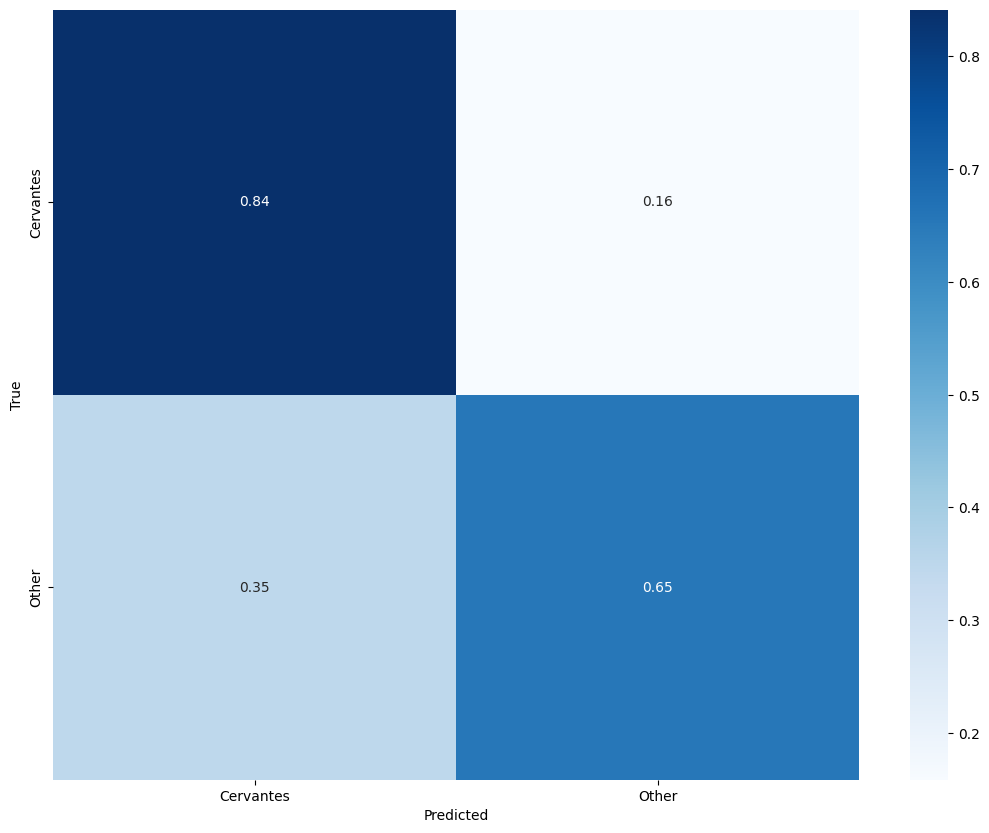

In [ ]:
plt.subplots(figsize=(13,10))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
clf = CalibratedClassifierCV(clf) 
clf.fit(X_dev, y_dev)
y_proba = clf.predict_proba(X_test)

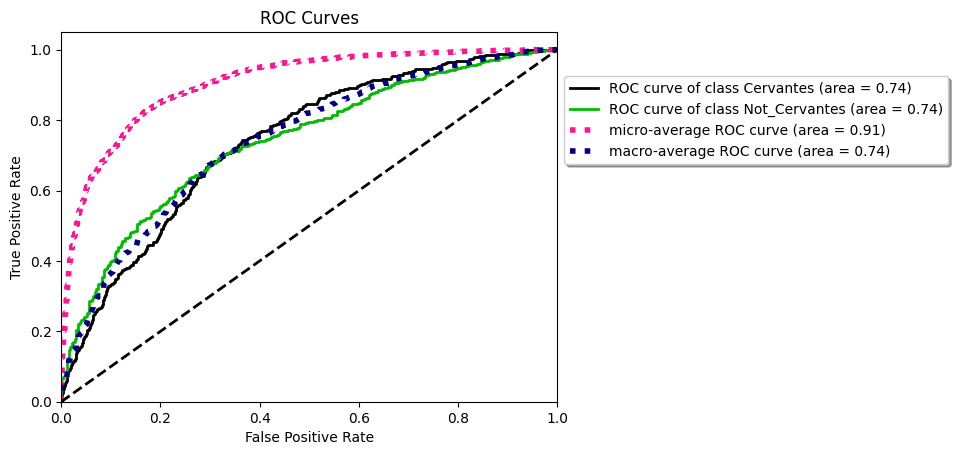

In [ ]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()
#print(roc_auc_score(y_test, y_proba))

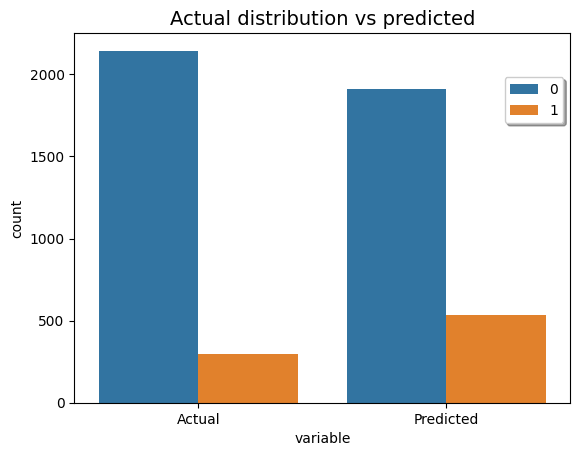

In [ ]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

In [ ]:
import random

random.randint(1,19)

18

# Binary classification task

## Preprocessing

### Binarizing target label

### Partitioning

In [ ]:
X = splitted_docs[0]
y_bin = [author if author == 'Cervantes' else 'Not_Cervantes' for author in splitted_docs[1]]  #splitted_docs[1]

NameError: name 'splitted_docs' is not defined

In [ ]:
X_dev, X_test, y_dev_bin, y_test_bin = train_test_split(
    X, y_bin, test_size=0.3, stratify=y_bin, random_state=42
)

### Features extraction

In [ ]:
%%time
fw_reductor = FeatureSetReductor(function_words_extractor)
fw_red_bin = fw_reductor.fit_transform(X_dev, authors=y_dev_bin)
fw_red_test_bin = fw_reductor.transform(X_test)

me_reductor = FeatureSetReductor(mendenhall_extractor)
me_red_bin = me_reductor.fit_transform(X_dev, authors=y_dev_bin)
me_red_test_bin = me_reductor.transform(X_test)

wm_reductor = FeatureSetReductor(words_masker)
wm_red_bin = wm_reductor.fit_transform(X_dev, authors=y_dev_bin)
wm_red_test_bin = wm_reductor.transform(X_test)

pos_reductor = FeatureSetReductor(POS_extractor)
pos_red_bin = wm_reductor.fit_transform(X_dev, authors=y_dev_bin)
pos_red_test_bin = wm_reductor.transform(X_test)

CPU times: user 2min 22s, sys: 91.9 ms, total: 2min 22s
Wall time: 2min 22s


In [ ]:
%%time
hstacker = HstackFeatureSet(function_words_extractor, words_masker, mendenhall_extractor)

hstacked_features_bin = hstacker._hstack([fw_red_bin, me_red_bin, wm_red_bin, pos_red_bin])
hstacked_features_test_bin = hstacker._hstack([fw_red_test_bin, me_red_test_bin, wm_red_test_bin, pos_red_test_bin])

CPU times: user 12.9 ms, sys: 0 ns, total: 12.9 ms
Wall time: 11.6 ms


In [ ]:
scaler = StandardScaler(with_mean=False)
features_norm = scaler.fit_transform(hstacked_features_bin)
features_norm_test = scaler.transform(hstacked_features_test_bin)

In [ ]:
X_dev = hstacked_features_bin#features_norm
X_test = hstacked_features_test_bin#features_norm_test

### Oversampling

In [ ]:
# sm = SMOTE(random_state=42)
# X_dev_oversampled, y_dev_bin_oversalmpled = sm.fit_resample(X_dev, y_dev_bin)
# np.unique(y_dev_bin_oversalmpled, return_counts=True)
# peggiore rispetto al contesto non bilanciato

### Model Building

In [ ]:
%%time
clf = LinearSVC(random_state=42, dual='auto', class_weight='balanced')
scores = cross_val_score(clf, X_dev, y_dev_bin, cv=5)
scores.mean(), scores.std()

CPU times: user 758 ms, sys: 0 ns, total: 758 ms
Wall time: 757 ms


(0.7704132335367004, 0.007604390559374385)

In [ ]:
# clf_lr = LogisticRegression(random_state=42, max_iter=100000)
# scores = cross_val_score(clf_lr, X_dev, y_dev_bin, cv=5)
# scores.mean(), scores.std()

### Model Evaluation

In [ ]:
clf.fit(X_dev, y_dev_bin)
y_pred_bin = clf.predict(X_test)
acc = accuracy_score(y_test_bin, y_pred_bin)
f1 = f1_score(y_test_bin, y_pred_bin, pos_label='Cervantes')

print('Accuracy:', acc) 
print('f1:',f1)

Accuracy: 0.7636502481863306
f1: 0.5556353194544149


In [ ]:
print(classification_report(y_test_bin, y_pred_bin))

               precision    recall  f1-score   support

    Cervantes       0.42      0.83      0.56       466
Not_Cervantes       0.95      0.75      0.84      2153

     accuracy                           0.76      2619
    macro avg       0.69      0.79      0.70      2619
 weighted avg       0.86      0.76      0.79      2619



con class_weight balanced peggiora la performance generale ma migliora la f1 sull'autore target Cervantes

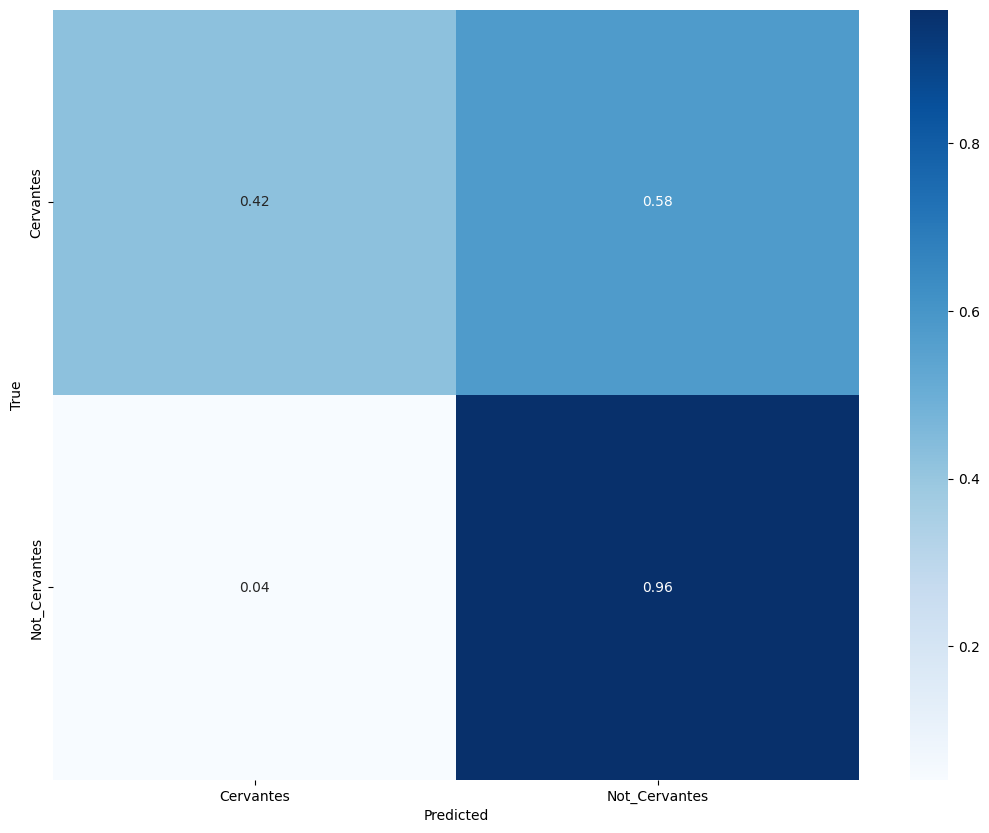

In [ ]:
plt.subplots(figsize=(13,10))
cf = confusion_matrix(y_test_bin, y_pred_bin, normalize='true')

sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=list(np.unique(y_bin)), yticklabels=list(np.unique(y_bin)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

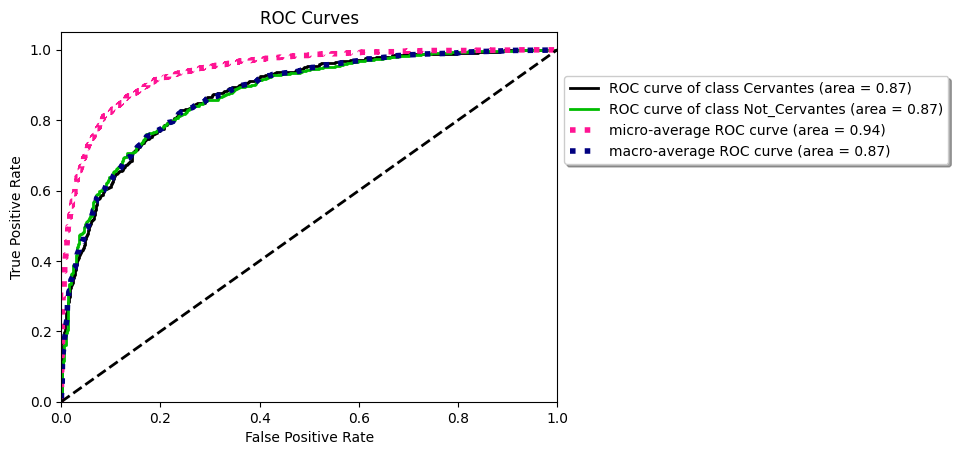

0.8726868786741326


In [ ]:
clf = CalibratedClassifierCV(clf) 
clf.fit(X_dev, y_dev_bin)
y_proba_bin = clf.predict_proba(X_test)
y_proba_bin = [y[1] for y in y_proba_bin]

plot_roc(y_test_bin, clf.predict_proba(X_test))
plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()
print(roc_auc_score(y_test_bin, y_proba_bin))

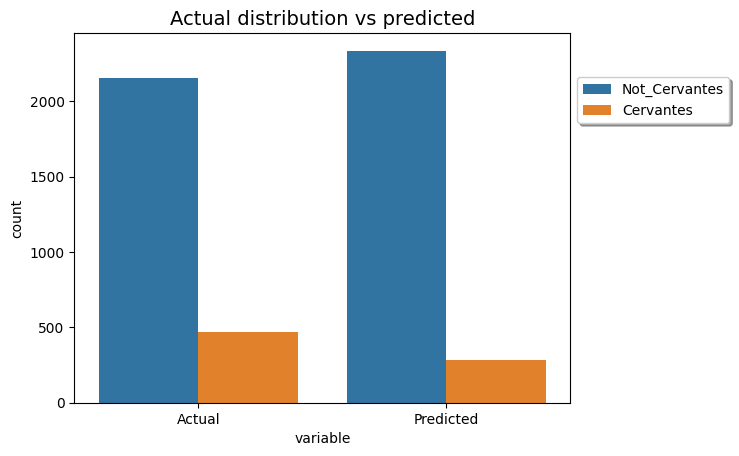

In [ ]:
df_res = pd.DataFrame({'Actual': y_test_bin, 'Predicted': y_pred_bin})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()